# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 4

In [1]:
from config import *

# This is needed to render the plots in this chapter
from plots.chapter4 import *

In [2]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import *

# Classifying Images

Enough already with simple data points: let’s classify images! Although the data is
different, it is still a classification problem, so we will try to predict which class an
image belongs to.

First, let’s generate some images to work with (so we don’t have to use MNIST[75]!).

## Data Generation

Our images are quite simple: they have black backgrounds and white lines drawn
on top of them. The lines can be drawn either in a diagonal or in a parallel (to one of
the edges, so they could be either horizontal or vertical) way. So, our classification
problem can be simply stated as: is the line diagonal?

If the line is diagonal, then we assume it belongs to the positive class. If it is not
diagonal, it belongs to the negative class. We got our labels (y), and we can
summarize them like this:

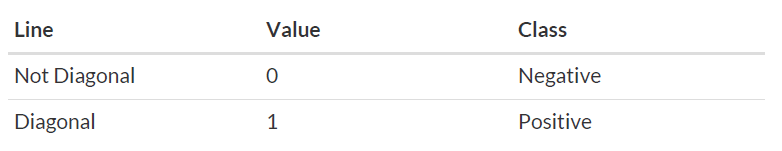

Let’s generate 300 random images, each one five-by-five pixels in size:

In [3]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

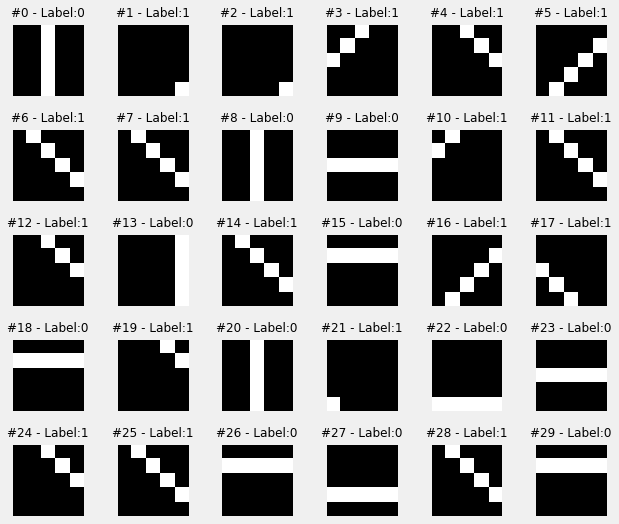

In [4]:
fig = plot_images(images, labels, n_plot=30)

Since our images are quite small, there aren’t that many possibilities for drawing
lines on top of them. There are actually 18 different configurations for diagonal
lines (nine to the left, nine to the right), and another 10 different configurations for
horizontal and vertical lines (five each). That’s a total of 28 possibilities in a 300-
image dataset. So there will be lots of duplicates (like images #1 and #2, or #6 and
#7, for example), but that’s fine.

## Images and Channels


In case you’re not familiar with the meaning of channels, pixel values, and
how images are represented as tensors, this is a brief overview of these
topics.
To illustrate how images are represented, let’s create three separate images
first:

In [5]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

Each one of these images is five-by-five pixels and is represented by a fiveby-
five matrix. It is a two-dimensional representation, which means it is a
single-channel image. Moreover, its dtype is np.uint8, which only accepts
values from zero to 255.

> If an image has only one channel, it is a grayscale image.
The range of pixel values goes from zero (black) to 255
(white), and everything in between is a shade of gray

Taken individually, they are three images with vertical stripes. But we can
pretend they represent different colors: red, green, and blue. These three
colors are the base colors used to build all others. That’s where the RGB
acronym comes from!
If we perform a weighted average of these three colors, we’ll get another
grayscale image. This should be no surprise since it still has only one
channel.

In [6]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

In [7]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

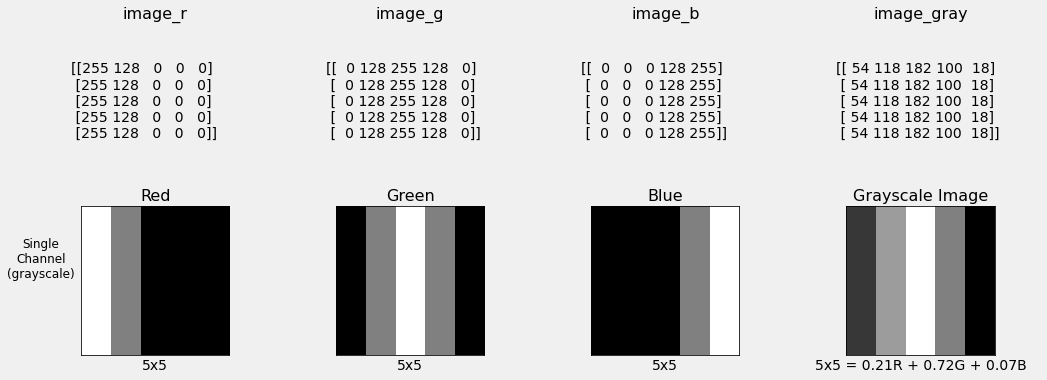

In [8]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

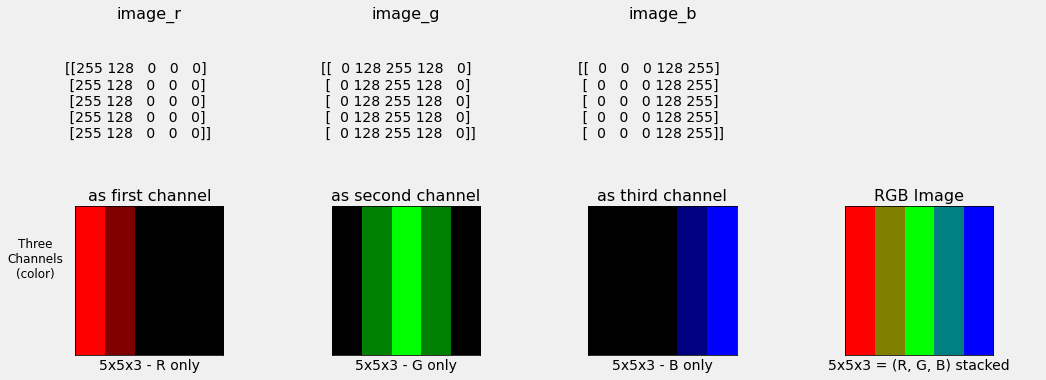

In [9]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

### NCHW vs NHWC

- **N** stands for the Number of images (in a mini-batch, for instance)
- **C** stands for the number of Channels (or **filters**) in each image
- **H** stands for each image’s Height
- **W** stands for each image’s Width

Thus the acronyms indicate the expected shape of the mini-batch:

- **NCHW**: (number of images, channels, height, width)
- **NHWC**: (number of images, height, width, channel)

Basically, everyone agrees that the **number of images comes first**, and that height
and width are an inseparable duo. It all comes down to the **channels (or filters)**: for
each individual image, it may be either the first dimension (before HW) or the last
dimension (after HW).

There are endless discussions about which format is better, faster, or whatever.
We’re not getting into this discussion here. Nonetheless, we need to address this
difference because it is a common source of confusion and error since each
package or framework uses a different one:

- PyTorch uses **NCHW**
- TensorFlow uses **NHWC**
- PIL images are **HWC**

Annoying, right? I think so, too. But it is only a matter of paying close attention to
which format is coming in, and which format is coming out after an operation. Let’s
work our way through it.

Our dataset generates images following the PyTorch format, that is, NCHW.
What’s the shape of our dataset, then?

In [10]:
images.shape

(300, 1, 5, 5)

As expected, 300 images, single-channel, five pixels wide, five pixels high. Let’s take
a closer look at one image, say, image #7:

In [11]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

What would an image in the HWC look like? We can transpose the first dimension to become the last one using Numpy:

In [12]:
example.shape

(1, 5, 5)

In [13]:
example_hwc = np.transpose(example, (1, 2, 0))
example.shape, 'vs', example_hwc.shape

((1, 5, 5), 'vs', (5, 5, 1))

In [14]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Torchvision

Torchvision is a package containing popular datasets, model architectures, and
common image transformations for computer vision.

### Datasets

Many of the popular and common datasets are included out of the box, like MNIST,
ImageNet, CIFAR, and many more. All these datasets inherit from the original
Dataset class, so they can be naturally used with a DataLoader in exactly the same
way we’ve been doing so far.

There is one particular dataset we should pay more attention to: *ImageFolder*. This is not a dataset itself, but a **generic dataset** that you can use with your own images,
provided that they are properly organized into sub-folders, each sub-folder named
after a class and containing the corresponding images.


### Models

PyTorch also includes the most popular **model architectures**, including its pretrained
weights, for tackling many tasks like image classification, semantic
segmentation, object detection, instance segmentation, and person keypoint
detection, and video classification.

Among the many models, we can find the well-known AlexNet, VGG (in its many
incarnations: VGG11, VGG13, VGG16, and VGG19), ResNet (also in many flavors:
ResNet18, ResNet34, ResNet50, ResNet101, ResNet152), and Inception V3.

### Transforms

Torchvision has some common image transformations on its **transforms** module. It
is important to realize there are two main groups of transformations:

- transformations based on images (either in PIL or PyTorch shapes)
- transformations based on Tensors

Obviously, there are **conversion transforms** to convert from tensor `ToPILImage` and
from PIL image `ToTensor`.

Let’s start using ToTensor to convert a Numpy array (in PIL shape) to a PyTorch
tensor. We can create a "tensorizer" (for lack of a better name), and feed it our
example image (#7) in HWC shape:

In [15]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [16]:
example_hwc.shape

(5, 5, 1)

Cool, we got the expected CHW shape. So, its content should be easy to associate
with the underlying image:

In [17]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

And indeed it is: once again we can "see" the diagonal line. But, this time, its values
are not equal to 255 anymore, they are equal to 1.0 instead.

> ToTensor may **scale** the values **from a [0, 255] range to a [0.0, 1.0]
range**, if the input is either a Numpy array with dtype equals to
uint8 (as in our example) or a PIL image belonging to one of the
following modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1).

To more easily visualize
the resulting images, we may use `ToPILImage` to convert a tensor to a PIL image:

In [18]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


Notice that it is a real PIL image, not a Numpy array anymore, so we can use
Matplotlib to visualize it:

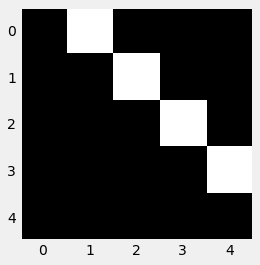

In [19]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

### Transforms on Images

These transforms include the typical things you’d like to do with an image for the
purpose of data augmentation: `Resize`, `CenterCrop`, `GrayScale`,
`RandomHorizontalFlip`, and `RandomRotation`, to name a few. Let’s use our example
image above and try some random horizontal flipping. But, just to make sure we
flip it, let’s ditch the randomness and make it flip 100% of the time:

In [20]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

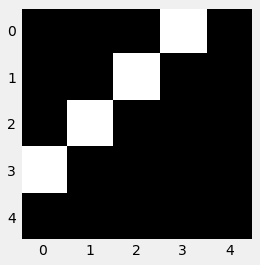

In [21]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

### Transforms on Tensor

There are **only four** transforms that take (non-image) tensors as inputs:
`LinearTransformation`, `Normalize`, `RandomErasing` (although I believe this one was
a better fit for the other group of transforms…), and `ConvertImageDtype`.

First, let’s transform our flipped image to a tensor using the tensorizer we’ve
already created:

In [22]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

#### Normalize Transform

Now we can apply one of the most common transformations: **Normalize**. In its
documentation, we can get a brief description of this transformation:

> Normalize a tensor image with mean and standard deviation. Given mean:
(mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this
transform will normalize each channel of the input torch.*Tensor i.e.,
output[channel] = (input[channel] - mean[channel]) / std[channel]

Does it look familiar? Remember the `StandardScaler` we have used in previous
chapters to standardize our features? That’s the tensor-based version of it,
operating independently on each image channel.

By definition, pixel values can only be positive, usually in the range [0, 255]. From
our image tensor, we see its values are in the [0, 1] range, and we have only one
channel. We can use the normalize transform to have its values mapped to a
symmetrical range.

But, instead of computing mean and standard deviation first (as we did in previous
chapters), let’s set the mean to 0.5 and set the standard deviation to 0.5 as well.

By doing so, we’ll be effectively performing a min-max scaling (like Scikit-Learn’s
MinMaxScaler) such that the resulting range is [-1, 1]. It is easy to see why, if we
compute the resulting values for the extremes of our original range [0, 1]:

$$
\Large
\begin{aligned}
\text{input} = 0 \implies \frac{0 - \text{mean}}{\text{std}}= \frac{0 - 0.5}{0.5}&=-1
\\
\text{input} = 1 \implies \frac{1 - \text{mean}}{\text{std}}= \frac{1 - 0.5}{0.5}&=1
\end{aligned}
$$

There we go: the resulting range is [-1, 1]. Actually, we could set it to anything we
want. Had we chosen a standard deviation of 0.25, we would get a [-2, 2] range
instead. If we had chosen a mean value different than the midpoint of the original
range, we would end up with an asymmetrical range as a result.

Now, if we take the trouble of actually computing the real mean and standard
deviation of the training data, we would have achieved an actual standardization,
that is, our training data would have zero mean and unit standard deviation.

For now, let’s stick with the lazy approach and use the Normalize transformation as
a min-max scaler to the [-1, 1] range:

In [23]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

Notice that the transformation takes two tuples as arguments, one tuple for the
means, another one for the standard deviations. **Each tuple has as many values as
channels in the image**. Since we have single-channel images, our tuples have a
single element each.

### Composing Transforms

No one expects you to run these transformations one by one, that’s what `Compose`
can be used for: **composing several transformations** into a single, big, composed,
transformation. Also, I guess I could have composed a better sentence to explain it
(pun intended).

It is quite simple, actually: just line up all desired transformations in a list. This
works pretty much the same way as a pipeline in Scikit-Learn. We only need to
make sure the output of a given **transformation** is an **appropriate input** for the
next one.

Let’s compose a new transformation using the following list of transformations:

- first, let’s **flip an image** using `RandomHorizontalFlip`
- next, let’s perform some **min-max scaling** using `Normalize`

In code, the sequence above looks like this:

In [24]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

If we use the composer above to transform the example tensor, we should get the
same normalized tensor as output. Let’s double check it:

In [25]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

Notice that we have not used the original example, a Numpy array already in
PyTorch shape (CHW), as input. To understand why, let’s briefly compare it to the
example_tensor we used as the actual input (a PyTorch tensor, also in CHW shape):

In [26]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


As you can see, the only differences between them are the scale (255 vs one) and
the type (integer and float). We can convert the former into the latter using a oneliner:

In [27]:
example_tensor = torch.as_tensor(example / 255).float()

Moreover, we can use this line of code to convert our whole Numpy dataset into tensors, so they become an appropriate input to our composed transformation.

## Data Preparation
The first step of data preparation, as in previous chapters, is to convert our
features and labels from Numpy arrays to PyTorch tensors:

In [28]:
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

The only difference is that we scaled the images to get them into the expected [0.0, 1.0] range.

### Dataset Transforms

Next, we use both tensors to build a Dataset, but not a simple TensorDataset like
before. Once again, we’ll build our own custom dataset, that is capable of handling
transformations. Its code is actually quite simple:

In [29]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

It takes **three arguments**: a tensor for **features (x)**, another tensor for **labels (y)**,
and an **optional transformation**. These arguments are then stored as **attributes** of
the class. Of course, if no transformation is given, it will behave similarly to a regular
TensorDataset.

The main difference is in the `__getitem__` method: instead of simply returning the
elements corresponding to a given index in both tensors, it **transforms the
features**, if a transformation is defined.

> "Do I have to create a custom dataset to perform transformations?"

Not necessarily, no. The `ImageFolder` dataset, which you’ll likely use for handling
real images, **handles transformations out-of-the-box**. The mechanism is
essentially the same: if a transformation is defined, the dataset applies it to the
images. The purpose of using yet another custom dataset here is to illustrate this
mechanism.

So, let’s redefine our composed transformations (so it actually flips the image
randomly instead of every time) and create our dataset:

In [30]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

Cool! But we still have to split the dataset as usual. But we’ll do it a bit differently
this time…

### SubsetRandomSampler

Previously, when creating a data loader for the training set, we used to set its
argument shuffle to True (since shuffling data points, in most cases, improves the
performance of gradient descent). This was a very convenient way of **shuffling** the
data, which was implemented using a `RandomSampler` under the hood. Every time a
new mini-batch was required, it **sampled some indices randomly**, and the data
points corresponding to those indices were returned.

Even when there was **no shuffling** involved, as in the data loader used for the
validation set, a `SequentialSampler` was used. In this case, whenever a new minibatch
was required, this sampler simply returned a sequence of indices, in order,
and the data points corresponding to those indices were returned.

In a nutshell, a **sampler** can be used to **return sequences of indices** to be used for
data loading. In the two examples above, each sampler would take a **Dataset** as an
argument. But not all samplers are like that.

The `SubsetRandomSampler` samples indices **from a list**, given as argument, without
replacement. As in the other samplers, these indices will be used to load data from
a dataset. If an index is not on the list, the corresponding data point will never be
used.

So, if we have **two disjoint lists of indices** (that is, no intersection between them, and they cover all elements if added together), we can create **two samplers** to effectively split a dataset. Let’s put this into code, to make it more clear.

First, we need to generate **two shuffled lists of indices**, one corresponding to the
points in the **training set**, the other, to the points in the **validation set**. We have
done this already using Numpy. Let’s make it a bit more interesting and useful this
time by assembling the **Helper Function #4**, aptly named `index_splitter`, to split
the indices:

### Helper Function #4

In [31]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

The function above takes three arguments:

- n: the **number of data points** to generate indices for
- splits: a list of values representing the **relative weights** of the split sizes
- seed: a random seed to ensure reproducibility

It always bugged me a little that PyTorch’s random_split needs a list with the exact
number of data points in each split. I wish I could give it proportions, like [80, 20], or [.8, .2], or even [4, 1], and then it would figure out how many points go into each split on its own. That’s the main reason index_splitter exists: we can give it relative weights, and it figures the number of points out.

Sure, it still calls `random_split` to split a tensor containing a list of indices (in
previous chapters, we used it to split Dataset objects instead). 

The resulting splits are Subset objects:

In [32]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

Each subset contains the corresponding indices as an attribute:

In [33]:
train_idx.indices[:10]

[118, 170, 148, 239, 226, 146, 168, 195, 6, 180]

Next, each **Subset** object is used as an argument to the corresponding sampler:

In [34]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

So, we can use a **single dataset** to load the data from since the split is controlled by
the samplers. But we still need **two data loaders**, each one using its corresponding
sampler:

In [35]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

> If you’re using a sampler, you cannot set shuffle=True.

We can also check if the loaders are returning the correct number of mini-batches:

In [36]:
next(iter(train_loader))[0].shape

torch.Size([16, 1, 5, 5])

In [37]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

There are 15 mini-batches in the training loader (15 mini-batches * 16 batch size =
240 data points), and four mini-batches in the validation loader (4 mini-batches *
16 batch size = 64 data points). In the validation set, the last mini-batch will have
**only 12 points, since there are only 60 points in total**.

OK, cool, this means we don’t need two (split) datasets anymore, we only need two samplers. Right? Well, **it depends.**

### Data Augmentation Transformations

No, I did not change topics :-) The reason why we **may still need two split datasets** is exactly that: **data augmentation**. 

In general, we want to apply data augmentation to the training data only (yes, there is test-data augmentation too, but that’s a different matter). But data augmentation is accomplished using **composing
transforms**, which will be applied to all points in the dataset. See the problem?

If we need some data points to be augmented, but not others, the easiest way to
accomplish this is to create two composers and use them in two different datasets.
We can still use the indices, though:

In [38]:
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

Then, here come the two composers: the `train_composer` augments the data, and
then scales it (min-max); the `val_composer` only scales the data (min-max).

In [39]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

Next, we use them to create two datasets and their corresponding data loaders:

In [40]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

And, since we’re not using a sampler to perform the split anymore, we can (and
should) set shuffle to True.

> If you do not perform data augmentation, you may keep using
samplers and a single dataset.

Disappointed with the apparently short-lived use of samplers? Don’t be! I saved
the best sampler for last.

### WeightedRandomSampler

We have already talked about **imbalanced datasets** when learning about binary
cross-entropy losses in Chapter 3. We adjusted the **loss weight** for points in the
positive class to compensate for the imbalance. It wasn’t quite the *weighted average*
one would expect, though. Now, we can tackle the **imbalance** using a different
approach: **a weighted sampler**.

The reasoning is pretty much the same but, *instead of weighted losses*, we use
**weights for sampling**: the class with **fewer data points (minority class)** should get
**larger weights**, while the class with **more data points (majority class)** should get
smaller weights. This way, on average, we’ll end up with mini-batches containing roughly the same number of data points in each class: a balanced dataset.

> "How are the weights computed?"

First, we need to find **how imbalanced** the dataset is, that is, how many data points
belong to each label. We can use PyTorch’s *unique* method on our training set
labels (`y_train_tensor`), with return_counts equals True, to get a list of the
**existing labels** and the corresponding **number of data points**:

In [41]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


Ours is a **binary classification**, so it is no surprise we have two classes: zero (not
diagonal) and one (diagonal). There are 80 images with lines that are not diagonal,
and 160 images with diagonal lines. Clearly, an imbalanced dataset.

Next, we use these counts to compute the weights, by inverting the counts. It is as
simple as that:

In [42]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

The first weight (0.0125) corresponds to the negative class (not diagonal). Since
this class has only 80 out of 240 images in our training set, it is also the **minority class**. The other weight (0.0063) corresponds to the positive class (diagonal), which
has the remaining 160 images thus making it the **majority class**.

> The minority class should have the largest weight, so each data
point belonging to it gets overrepresented to compensate for the
imbalance.

> *"But these weights do not sum up to one, isn’t it wrong?"*

It is usual to have weights summing up to one, sure, but this is **not required** by
PyTorch’s weighted sampler. We can get away with **weights inversely
proportional to the counts**. In this sense, the sampler is very "forgiving". But it is
not without its own quirks, unfortunately.

It is not enough to provide a sequence of weights corresponding to each different
class in the training set. It **requires** a sequence containing **the corresponding
weight for each and every data point** in the training set. Even though this is a bit
annoying, it is not so hard to accomplish: we can use the labels as indexes of the
weights we computed above. It is probably easier to see it in code:

In [43]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


Since there are 240 images in our training set, we need 240 weights. We squeeze our labels (y_train_tensor) to a single dimension and cast them to long type since
we want to use them as indices. The code above shows the first 10 elements, so you
can actually see the correspondence between class and weight in the resulting
tensor.

The sequence of weights is the main argument used to create the
`WeightedRandomSampler` but not the only one. Let’s take a look at its arguments:

- `weights`: a sequence of weights like the one we have just computed
- `num_samples`: how many samples are going to be drawn from the dataset
    - a typical value is the length of the sequence of weights, as you’re likely sampling from the whole training set
- `replacement`: if True (the default value), it draws samples with replacement
    - if `num_samples` equals the length, that is, if the whole training set is used, it makes sense to draw samples with replacement to effectively compensate for the imbalance.
    - it only makes sense to set it to `False` if `num_samples` < length of the dataset
- `generator`: optional, it takes a (pseudo) random number Generator that will be used for drawing the samples
    - to ensure reproducibility, we need to create and assign a generator (which has its own seed) to the sampler, since the manual seed we’ve already set is **not enough**
    
  
OK, we’ll sample from the whole training set, and we got our sequence of weights
ready. We are still missing a generator, though. Let’s create both the generator and
the sampler now:

In [44]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

> *"Didn’t you say we need to set a seed for the generator?! Where is it?"*

Indeed, I said it. We’ll set it soon, after assigning the sampler to the data loader.
You’ll understand the reasoning behind this choice shortly, please bear with me. So,
let’s (re-)create the data loaders using the weighted sampler with the training set:

In [45]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

Once again, if we’re using a sampler, we cannot use the `shuffle` argument.

There is a lot of boilerplate code here, right? Let’s build yet another function, Helper Function #5, to wrap it all up:

### Helper Function #5

In [46]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [47]:
sampler = make_balanced_sampler(y_train_tensor)

Much better! Its only argument is the tensor containing the labels: the function will
compute the weights and build the corresponding weighted sampler on its own.

### Seeds and more (seeds)

Time to set the **seed** for the **generator** used in the **sampler** assigned to the **data loader**. It is a long sequence of objects, but we can work our way through it to
retrieve the generator and call its `manual_seed` method:

In [48]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

Now we can check if our sampler is doing its job correctly. Let’s have it sample a full
run (240 data points in 15 mini-batches of 16 points each), and sum up the labels so we know how many points are in the positive class:

In [49]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

Close enough! We have 160 images of the positive class, and now, thanks to the
weighted sampler, we’re sampling only 123 of them. It means we’re oversampling
the negative class (which has 80 images) to a total of 117 images, adding up to 240
images. Mission accomplished, **our dataset is balanced now.**

> "Wait a minute! Why on Earth there was an extra seed in the code
above? Don’t we have enough already?"

I agree, too many seeds. Besides one specific seed for the generator, we also have
to set yet another seed for Python’s random module.

It’s better to be **safe** than sorry, so we better **set yet another seed to ensure the
reproducibility** of our code.

And that’s **exactly** what we’re going to do! Remember the set_seed method we
implemented in Chapter 3? Let’s update it to include more seeds:

In [50]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass
    
setattr(StepByStep, 'set_seed', set_seed)

Four seeds and counting! Our updated method tries to update the seed of the
generator used by the sampler assigned to the data loader of the training set. But, if
there is no generator (the argument is optional, after all), it fails silently.

### Putting It Together

We’ve gone through a lot of things regarding the data preparation step. Let’s put
them all together to get a better view of the big picture here.

First, we’ve built a **custom dataset** to handle **transforms on tensors**, and two
helper functions to handle boilerplate code for **splitting indices** and building a
**weighted random sampler**.

Then, we performed **many different processing steps as data preparation:**
- modifying the **scale of pixel values** from [0, 255] to [0, 1]
- **splitting** indices and tensors into training and validation sets
- building **composed transforms**, including data augmentation in the training set
- using a custom dataset to **apply transforms to tensors**
- creating a **weighted random sampler** to handle **class imbalance**
- creating **data loaders**, using the sampler together with the training set

### Data preparation

In [51]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Pixels as Features

So far, we’ve been handling our data as either PIL images or three-dimensional
tensors (CHW) with shape (1, 5, 5). It is also possible to consider each pixel and
channel as an individual feature by **flattening the pixels** with a `Flatten` layer. Let’s
take one mini-batch of images from our training set to illustrate how it works:

In [52]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [53]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


By default, it preserves the first dimension such that we **keep the number of data
points** in the mini-batch, but it collapses the remaining dimensions.

> "Don’t we **lose information** when we **flatten pixels?**"


Sure we do! And that’s why **Convolutional Neural Networks (CNNs)**, which we’ll
cover in the next chapter, are so successful: they do not lose this information. But,
for now, let’s do it really old style and flatten the pixels. It will make it much simpler
to illustrate a couple of other concepts before we get to the fancier CNNs.

Now, assuming the flattened version of our dataset, I ask you:
> "How is this different from the datasets we worked with in previous
chapters?"

**It isn’t!** Before, our data points were tensors with one or two elements in it, that is,
one or two features. Now, our data points are tensors with 25 elements in it, each
one corresponding to a pixel/channel in the original image, as if they were 25
"features".

And, since it is not different, apart from the number of features, we can start from
what we already know about defining a model to handle a binary classification task.

## Shallow Model

Guess what? It is a **logistic regression**:

$$
\Large \text{P}(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$

Given **25 features**, x_0 through x_24, each one corresponding to the value of a pixel in
a given channel, the model will fit a linear regression such that its outputs are logits (z), which are converted into probabilities using a sigmoid function.

> "Oh no, not this again… where are the deep models?"

Don’t worry, this section was named shallow model for a reason… in the next one,
we’ll build a deeper model with a hidden layer in it - finally!

How does our model look like? Visualization always helps, so here we go:

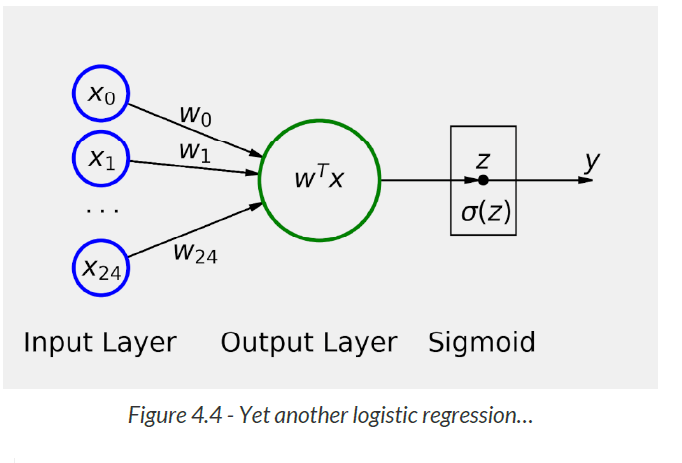

> "Wait, where is the bias?"

I am glad you noticed. I removed it on purpose! I want to illustrate the difference
between a **shallow model** like this, and a deeper one, and it is much easier to work
it out if we ditch the bias. Moreover, I would also like to recall the corresponding
notation for our model, since I am planning on using this notation to illustrate that
point.

![](images/classification.png)

### Notation

The vectorized representations of the **weights (W)** and **features (X)** are:

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X = 
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

The logits (z), as shown in Figure 4.4 are given by the expression below:

$$
\Large 
\begin{aligned}
z
& = W^T \cdot X 
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}} 
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration

As usual, we only need to define a **model**, an appropriate **loss function**, and an
**optimizer**. Since we have **five-by-five single-channel images** as inputs now, we
need to **flatten** them first, so they can be proper inputs to our **linear layer (without
bias)**. We will keep using the SGD optimizer with a learning rate of 0.1 for now.

This is what the model configuration looks like for our classification problem:

In [54]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

Let’s train our model for 100 epochs using the StepByStep class and visualize the
losses:

In [55]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

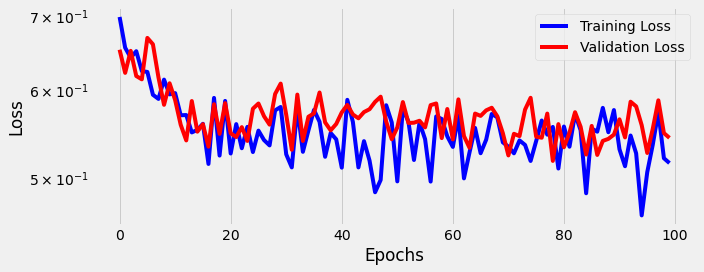

In [56]:
fig = sbs_logistic.plot_losses()

Awful, right? It seems our model is barely learning anything! Maybe a deeper
model can do better.

## Deep-ish Model

There we go, let’s add not one, but **two hidden layers** to our model and make it
deep-ish. We still start with a Flatten layer, and the last part of our model still is a
Sigmoid, but there are two extra Linear layers before the already existing output
layer.
Let’s visualize it:

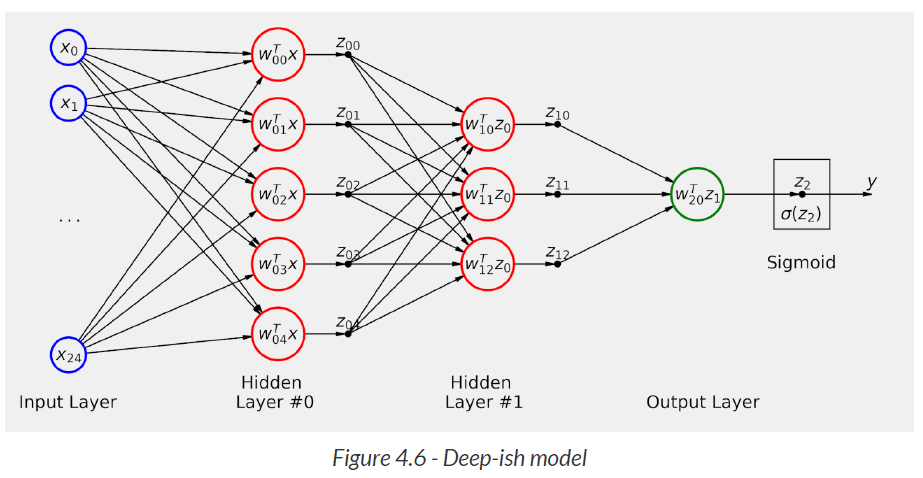![](images/classification_equiv.png)

By the way, in the figure above, the subscripts for both `w` and `z` represent the zerobased
indices for layer and unit: in the output layer, for instance, `w20` represents the
weights corresponding to the first unit (#0) of the third layer (#2).

What’s happening here? Let’s work out the **forward pass**, that is, the path from
inputs (x) to output (y):

1. an image is **flattened** to a tensor with 25 features, from x0 to x24 (not depicted
in the figure above)
2. the 25 **features are forwarded** to each one of the five units in **Hidden Layer #0**
3. each unit in Hidden Layer #0 use its weights, from w00 to w04, and the features
from the Input Layer to compute its corresponding outputs, from z00 to z04
4. the outputs of Hidden Layer #0 are forwarded to each one of the three units in
Hidden Layer #1 (in a way, the outputs of Hidden Layer #0 work as if they were
features to the Hidden Layer #1)
5. each unit in Hidden Layer #1 uses its weights, from w10 to w12, and the z0 values
from the preceding hidden layer to compute its corresponding outputs, from z10
to z12
6. the outputs of Hidden Layer #1 are forwarded to the single unit in the output layer (again, the outputs of Hidden Layer #1 work as if they were features to the
Output Layer )
7. the unit in the Output Layer uses its weights (w20), and the z1 values from the
preceding hidden layer to compute its corresponding output (z2)
8. z2 is a logit, which is converted to a probability using a sigmoid function


There are a couple of things to highlight:

- **all** units in the hidden layers, and the one in the output layer, take a set of
inputs (x or z) and perform the same operation (wTx or wTz, each using its own
weights, of course), producing an output (z)
- in the hidden layers, these operations are exactly like the logistic regression
models we used so far, up to the point where the logistic regression produced a
logit
- it is perfectly fine to think of the **outputs of one layer as features of the next
layer**; actually, this is at the heart of the **transfer learning** technique we’ll see in
Chapter 7
- for a binary classification problem, the **output layer is a logistic regression**,
where the "features" are the outputs produced by the previous hidden layer

Not so complicated, right? It actually seems like a natural extension of the logistic
regression. Let’s see how it performs in practice.

### Model Configuration

In [58]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [59]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

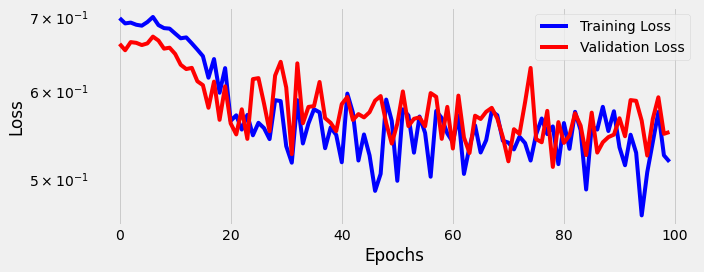

In [60]:
fig = sbs_nn.plot_losses()

Well, that does not look good at all! It seems even worse than the logistic
regression. Or is it? Let’s plot them both on the same chart to more easily compare
them:

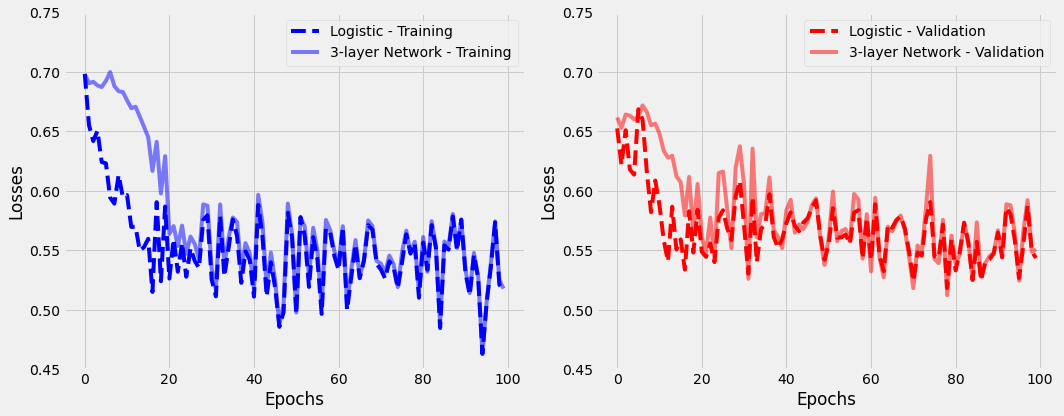

In [61]:
fig = figure5(sbs_logistic, sbs_nn)

Apparently, the deep-ish model is neither better nor worse, it is **unbelievably similar**. There’s got to be something wrong, after all, a deeper model should
perform, **if not better, at least, differently from a plain logistic regression.**

> "What are we missing?"
We are missing the **activation functions**!

- An activation function is a nonlinear function that transforms
the outputs of the hidden layers, in a similar way the sigmoid
function transforms the logits in the output layer.

- Actually, the sigmoid is one of many activation functions. There
are others, like the hyperbolic-tangent (tanh) and the Rectified
Linear Unit (ReLU).

- A deeper model **without activation functions** in its hidden layers
is no better than a linear or logistic regression. That’s what I
wanted to illustrate with the two models we’ve trained, the
shallow and the deep. That’s why I removed the bias in both
models too: it makes the comparison more straightforward.

### Show Me the Math!

This subsection is **optional**. If you’re curious to understand, using matrix
multiplications, why our deep-ish model is equivalent to a logistic regression,
check the sequence of equations below.

The deep-ish model is above the line, each row corresponding to a layer. The data
flows from right to left (since that’s how one multiplies a sequence of matrices),
starting with the 25 features on the right and finishing with a single logit output on
the left. Looking at each layer (row) individually, it should also be clear that the
outputs of a given layer (each row’s left-most vector) are the inputs of the next
layer, the same way the features are the inputs of the first layer.

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden}\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden}\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
\\
\hline
\text{substituting } z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
& &
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
& &
& &
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{multiplying...} & &
=
&
\underbrace{
\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}}_{\text{Matrices Multiplied}}
&
& & & & & & & &
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\end{array}
$$

The first row below the line shows the sequence of matrices. The bottom row
shows the result of the matrix multiplications. This result is exactly the same
operation shown in the "Notation" subsection of the shallow model, that is, the
logistic regression.

**In a nutshell, a model with any number of hidden layers has an equivalent model
with no hidden layers.** Sure, we’re not including the bias here because it would
make it much harder to illustrate this point.

### Show Me the Code!

If equations are not your favorite way of looking at this, let’s try using some code.
First, we need to get the weights for the layers in our deep-ish model. We can use
the weight attribute of each layer, without forgetting to `detach()` it from the
computation graph, so we can freely use them on other operations:

In [62]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

The shapes should match both our model’s definition and the weight matrices in
the equations above the line.

We can compute the bottom row, that is, the equivalent model using matrix
multiplication (which happens from right to left, as in the equations):

In [63]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

It is performing a matrix multiplication, exactly like `torch.mm` does. We could have
written the expression above like this:

In [61]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In my opinion, the sequence of operations looks more clear using "@" for matrix
multiplication.

Next, we need to compare them to the weights of the shallow model, that is, the
logistic regression:

In [64]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

torch.Size([1, 25])

Same shape, as expected. If we compare the values, one by one, we’ll find that they
are similar, but not quite the same. Let’s try to grasp the full picture by looking at a
picture (yes, pun intended!):

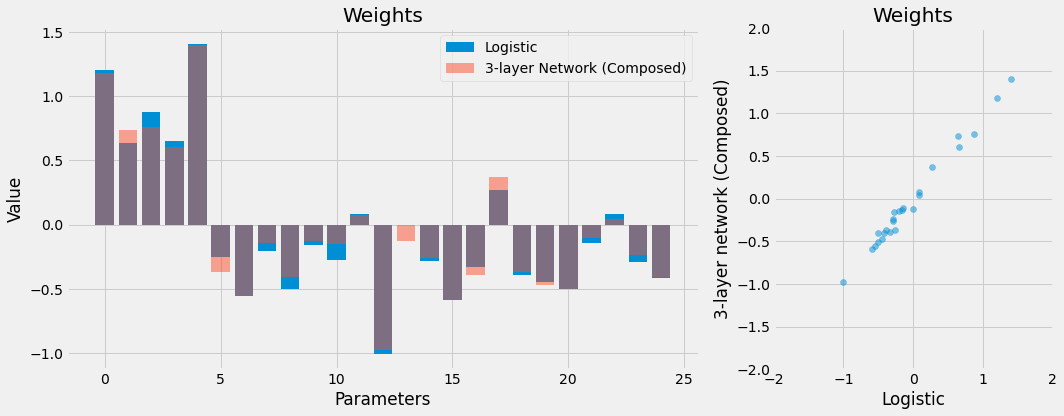

In [65]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

On the left, we plot all the 25 weights/parameters for both models. Even though
they are not quite the same, the similarity is striking. On the right, we can
appreciate that the weights are, indeed, highly correlated.

> "If the models are equivalent, how come the weights ended up being
slightly different?"

That’s a fair question. First, remember that every model is **randomly initialized**. We
did use the same random seed, but this was not enough to make both models
identical at the beginning. 

Why not? Simply put, the deep-ish model had many
more weights to be initialized, so they couldn’t have been identical at the start.
It is fairly straightforward that the logistic regression model has 25 weights. But
how many weights does the deep-ish model have? We could work it out: 25
features times five units in Hidden Layer #0 (125), plus those five units times three
units in Hidden Layer #1 (15), plus the last three weights from Hidden Layer #1 to
the Output Layer, adding up to a total of 143.

Or we could just use PyTorch’s `numel` instead to return the total number of
elements (clever, right?) in a tensor:

In [68]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [69]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

### Weights as Pixels

During data preparation, we flattened the inputs from five-by-five images to 25-
element long tensors. Here is a crazy idea: **what if we take some other tensor with
25 elements in it and try to visualize it as an image?**

We have some perfect candidates for this: the **weights** used by each unit in Hidden
Layer #0. Each unit uses 25 weights since each unit receives values from 25
features. We even have these weights in a variable already:

In [70]:
w_nn_hidden0.shape

torch.Size([5, 25])

Five units, 25 weights each. Perfect! We only need to use view to make the 25-
element long tensors representing the weights into two-dimensional tensors
(5x5), and visualize them as if they were images:

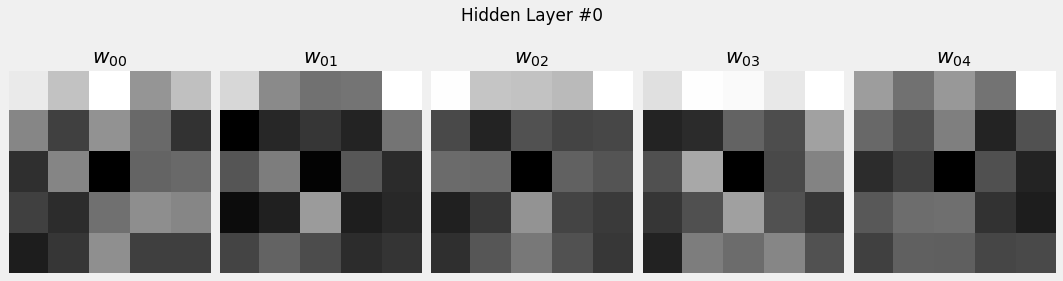

In [71]:
fig = figure7(w_nn_hidden0)

Visualizing weights as images is commonplace when using Convolutional Neural
Networks (CNNs). These images will be called filters, and trained models will likely
exhibit more recognizable characteristics in its filters. Since our model was poorly
trained, it’s no wonder the images above are not very informative. Moreover, in our
case, these are not quite "filters", since they have the same size as the input image.
In CNN-based models, real filters cover only part of the image. We’ll get back to it
in the next chapter.

## Activation Functions

> "What are activation functions?"

Activation functions are **nonlinear functions**. They either squash or bend straight
lines. They will **break the equivalence** between the deep-ish and the shallow model.

> "What exactly do you mean by squash or bend straight lines?"

Excellent question! Please hold this thought, I will illustrate this in the next
chapter, "Feature Space". First, let’s take a look at some common activation
functions. PyTorch has plenty of activation functions to choose from, but we are
focusing on five of them only.

### Sigmoid

Let’s start with the most traditional of the activation functions, the sigmoid, which
we’ve already used to transform logits into probabilities. Nowadays, that is pretty
much its only usage, but in the early days of neural networks, one would find it
everywhere!

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter4.py:175: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


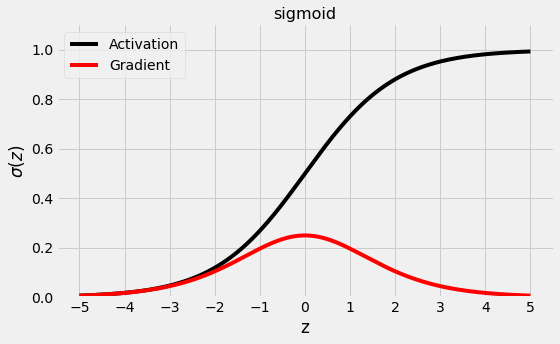

In [72]:
fig = plot_activation(torch.sigmoid)

Let’s quickly recap the shape of a **sigmoid**: as you can see in the figure above, a
**sigmoid activation function “squashes”** its input values (z) into the range (0, 1)
(same range probabilities can take, the reason why it is used in the output layer for
binary classification tasks). It is also possible to verify that its gradient peak value
is only 0.25 (for z = 0) and that it gets already close to zero as the absolute value of z
reaches a value of five.

Also, remember that the activation values of any given layer are the inputs of the
following layer and, given the range of the **sigmoid**, the activation values are going
to be **centered around 0.5**, instead of zero. This means that, even if we normalize
our inputs to feed the first layer, **it will not be the case anymore for the other
layers.**

> "Why does it matter if the outputs are centered around zero or not?"

In previous chapters, we **standardized** features (zero mean, unit standard
deviation) to improve the performance of gradient descent. The same reasoning
applies here since the outputs of any given layer are the inputs of the following
layer. There is actually more to it, and we’ll briefly touch this topic again in the
ReLU activation function when talking about the "internal covariate shift".

PyTorch has the sigmoid function available in **two flavors**, as we’ve already seen it
in Chapter 3: `torch.sigmoid` and `nn.Sigmoid`. The first one is a simple function, and
the second one is a full-fledged class inherited from nn.Module, thus being, for all
intents and purposes, a model on its own.

In [74]:
dummy_z = torch.tensor([-3., 0., 3.])

torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [75]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

### Hyperbolic Tangent (Tanh)

The hyperbolic tangent activation function was the evolution of the sigmoid, as its
outputs are values with a zero mean, differently from its predecessor.

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter4.py:175: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


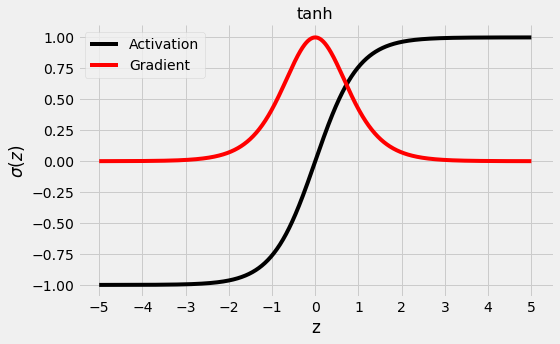

In [76]:
fig = plot_activation(torch.tanh)

As you can see in the figure above, the **tanh activation function “squashes”** the
input values into the **range (-1, 1)**. Therefore, being centered at zero, the activation
values are already (somewhat) normalized inputs for the next layer, making the
hyperbolic tangent a better activation function than the sigmoid.

Regarding the **gradient**, it has a much bigger peak value of 1.0 (again, for z = 0), but
its **decrease is even faster**, approaching zero to absolute values of z as low as three.

This is the underlying cause of what is referred to as the problem of **vanishing
gradients**, which causes the training of the network to be progressively slower.

Just like the sigmoid function, the hyperbolic tangent also comes in two flavors:
`torch.tanh` and `nn.Tanh`.

In [77]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [78]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

### Rectified Linear Unit (ReLU)

Maybe "squashing" is not the way to go… what if we bend the rules a bit and use an
activation function that **bends** (yay, another pun!) the line? The **ReLU** was born like
that, and it spawned a whole family of similar functions! The **ReLU**, or one of its
relatives, is the commonplace choice of activation function nowadays. It addresses
the problem of **vanishing gradients** of its two predecessors, while also being the
**fastest** to compute gradients for.

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
\\
& \text{or}
\\
\sigma(z) &= \text{max}(0, z)
\end{aligned}
$$

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter4.py:175: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


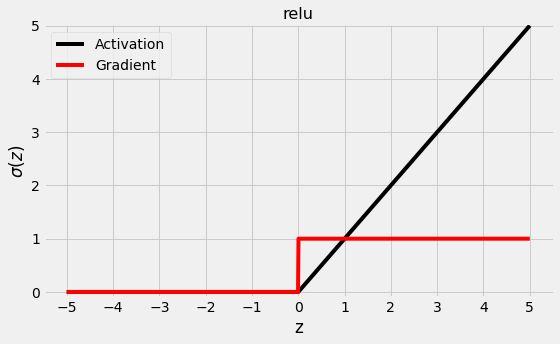

In [79]:
fig = plot_activation(torch.relu)

As you can see in the figure above, the **ReLU** is a totally different beast: it does not
“squash” the values into a range — it simply **preserves positive values** and turns all
negative values into zero.

The upside of using a **ReLU** is that its **gradient** is either one (for positive values) or
zero (for negative values) — no more vanishing gradients! This pattern leads to a
**faster convergence of the network**. 

On the other hand, this behavior can also lead
to what it is called a **“dead neuron”**, that is, a neuron whose inputs are consistently
negative and, therefore, always has an activation value of zero. Worse yet, the
gradient is also zero for negative inputs, meaning the weights are not updated. It’s
like the neuron got stuck.

The activation values of the ReLU are obviously **not centered at zero**. Does it make
it worse than the hyperbolic tangent? It surely doesn’t, otherwise it would not have
become such a popular activation function among practitioners. The ReLU, having
its comparably bigger gradients, is able to achieve better and faster results than
the other two activation functions despite the fact **its outputs are not centered at
zero.**

> For deeper and more complex models, this may become an issue
commonly called "internal covariate shift", which is just fancy for
**different distributions** of activation values in different layers. In
general, we would like to have all layers producing activation
values with **similar distributions**, ideally zero centered and with
**unit standard deviation.**
To address this issue, you can use **normalization layers**such as
BatchNorm. We’ll get back to it in Chapter 7.

There are **three different ways** of implementing a ReLU in PyTorch: `F.ReLU`,
`nn.ReLU`, and `clamp`.

> "What is this F? Why isn’t it torch anymore?"

The **F** stands for **functional**, and it is a common abbreviation for
`torch.nn.functional` (as we did in the "Imports" at the beginning of this chapter).

The functional module has lots of, well… functions, many of them performing the
operation of the corresponding module. In this case, **there is a `F.ReLU`, which is
actually called by the forward method of its corresponding module nn.ReLU.**

Some functions, like sigmoid and tanh, have been deprecated from the functional
module and moved to the torch module. This is not the case for ReLU and its
relatives, though, which remain functional:

In [80]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [81]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [82]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

### Leaky ReLU

How can you give a "dead neuron" a chance to come back to life? If the underlying
problem is the fact that it got stuck, we need to nudge it a bit. And that’s what a
**Leaky ReLU** does: **for negative inputs, it returns a tiny activation value and yields a
tiny gradient, instead of a fixed zero for both**. The multiplier for negative values,
0.01, is called the **coefficient of leakage**.

It may not be much, but it gives the neuron **a chance to get unstuck**. And it keeps
the nice properties of the ReLU: bigger gradients and faster convergence.

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
0.01z,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+0.01\ \text{min}(0,z)
\end{aligned}
$$

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter4.py:175: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


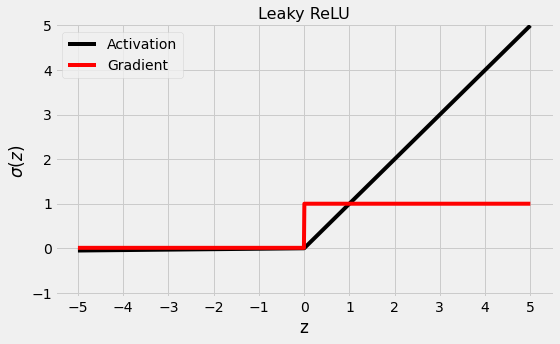

In [83]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

As you can see in the figure above, the Leaky ReLU is pretty much the same as the
ReLU, except for the tiny, barely visible, slope on the left-hand side.

Once again, we have two options. Functional (F.leaky_relu):

In [84]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [85]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

As you can see, in PyTorch, the coefficient of leakage is called `negative_slope`, with
a default value of 0.01.

> "Any particular reason to choose 0.01 as the coefficient of leakage?"

Not really, it is just a small number that enables the update of the weights, which
leads to another question: why not trying a different coefficient? Sure enough,
people started using other coefficients to improve performance.

> "Maybe the model can learn the coefficient of leakage too?"

Sure it can!

### Parametric ReLU (PReLU)

The **Parametric ReLU** is the natural evolution of the Leaky ReLU: instead of
arbitrarily choosing a coefficient of leakage (such as 0.01), let’s make it a
parameter (`a`). Hopefully, the model will learn how to prevent dead neurons, or
how to bring them back to life (zombie neurons?!). Jokes aside, that’s an ingenious
solution to the problem.

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
az,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+a\ \text{min}(0,z)
\end{aligned}
$$

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter4.py:175: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


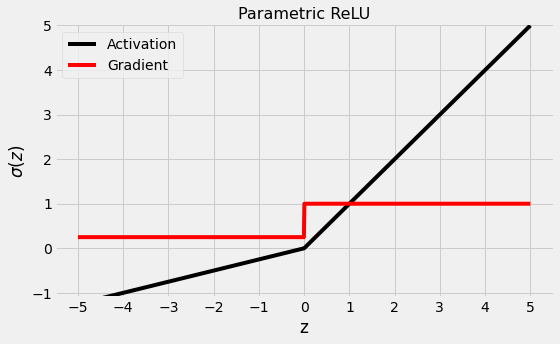

In [86]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

As you can see in the figure above, the slope on the left-hand side is much bigger
now, 0.25 to be precise, PyTorch’s default value for the parameter a.

We can set the parameter a using the functional version (argument weight in
`F.prelu`):

In [87]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.7500,  0.0000,  3.0000])

But, in the regular module (`nn.PReLU`), it doesn’t make sense to set it, since it is going
to be learned, right? We can still set the initial value for it, though:

In [88]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluBackward0>)

Did you notice the grad_fn attribute on the resulting tensor? It shouldn’t be a
surprise, after all, where there is **learning**, there is a **gradient**.

## Deep Model

Now that we’ve learned that activation functions **break the equivalence** to a
shallow model, let’s use them to transform our former deep-ish model into a real
deep model. It has the same architecture as the previous model, except for the
**activation functions** applied to the outputs of the hidden layers. Here is the
diagram of the updated model:

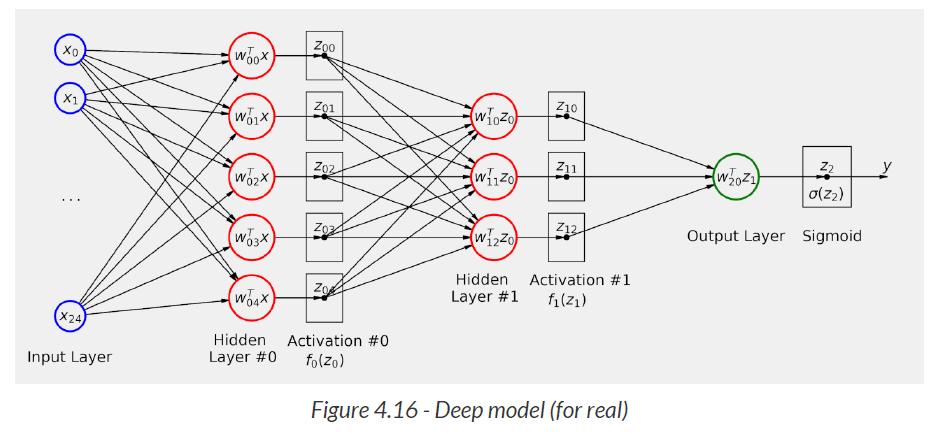

### Model Configuration

In [89]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

The chosen activation function is the Rectified Linear Unit (ReLU), one of the most
commonly used functions.
We kept the bias out of the picture for the sake of comparing this model to the
previous one, which is completely identical except for the activation functions
introduced after each hidden layer.

> In real problems, as a general rule, you should **keep** `bias=True`.

### Model Training

In [90]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

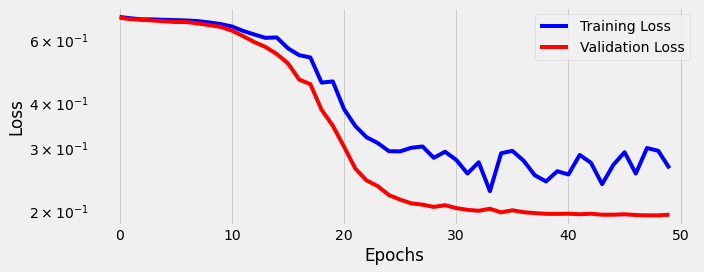

In [91]:
fig = sbs_relu.plot_losses()

This is more like it! But, to really grasp the difference made by the activation
functions, let’s plot all models on the same chart:

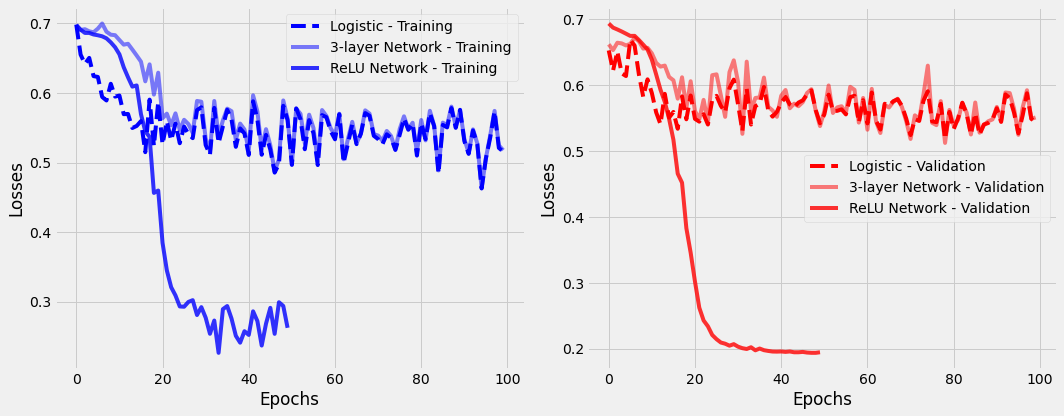

In [92]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)

It took only a handful of epochs for our new model to outperform the previous one.
Clearly, this model is not equivalent to a logistic regression: it is much, much
better.

To be completely honest with you, both models are kinda crappy. They perform
quite poorly if you look at their accuracies (ranging from 43% to 65% for the
validation set). The sole purpose of this exercise is to demonstrate that activation
functions, by breaking the equivalence to a logistic regression, are capable of
achieving better results in minimizing losses.

This particular model also exhibits a **validation loss** lower than the **training loss**,
which isn’t what you generally expect. We’ve already seen a case like this in
Chapter 3: the validation set was easier than the training set. The current example
is a bit more nuanced than that… here is the explanation:

- short version: this is a quirk!
- long version: 
    - first, our model is not so great and has a tendency to predict more points in the positive class (high FPR and TPR);
    - second, one of the mini-batches from the validation set has almost all of its points in the positive class, so the loss is very low; 
    - third, there are only four mini-batches in the validation set, so the average loss is easily affected by a single mini-batch.

It’s time to ask ourselves two questions:
  - why is the equivalence to a logistic regression broken?
  - what exactly are the activation functions doing under the hood?
  
The first question is answered in the next subsection, "Show Me the Math Again!".

The other, and more interesting question, is answered in the next chapter, "Feature
Space".


### Show Me the Math Again!

This subsection is also optional. If you’re curious to understand, using matrix
multiplications, why our deep model is not equivalent to a logistic regression
anymore, check the sequence of equations below.

As before, the data **flows from right to left** (since that’s how one multiplies a
sequence of matrices), starting with the **25 features on the right** and finishing with
a single **logit output on the left**. Looking at each layer (row) individually, it should
also be clear that the outputs of a given layer (the row’s left-most vector) are
transformed by an activation function before turning into inputs of the next layer.

The row below the line shows the result of composing all operations above the
line. There is no way to further simplify the expression due to the existence of the
two **activation functions** (`f0` and `f1`). They indeed break the equivalence to a logistic
regression.

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden }\#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden }\#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{\text{Activation #0}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{\text{Activation #1}}
\\
\hline
\text{substituting z's...} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
\right.
&
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
\right.
&
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{\text{Inputs}}
\right)
\right)
\end{array}
$$

## Putting It All Together

In this chapter, we have focused mostly on the **data preparation** part of our
pipeline. Sure, we got a fancier and deeper model, activation functions, and all, but
the model configuration part hasn’t changed, and neither the model training.

This should not come as a surprise since it is somewhat common knowledge that a
data scientist spends more time on data preparation than on actual model
training.

In [93]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [94]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [95]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

Data preparation

In [96]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

Model configuration

In [97]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

Model training

In [98]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)